In [ ]:

# 📦 Importar bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [ ]:

# 🔽 Carregar dados JSON da URL oficial
url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/main/TelecomX_Data.json"
df = pd.read_json(url)
df.head()


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [ ]:

# 🛠️ Expandir colunas aninhadas
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])

# Combinar tudo
df_final = pd.concat([df[['customerID', 'Churn']], df_customer, df_phone, df_internet, df_account], axis=1)

# Padronizar colunas
df_final.columns = df_final.columns.str.lower().str.replace(' ', '_').str.replace('.', '_')
df_final.rename(columns={'customerid': 'customer_id', 'churn': 'churn'}, inplace=True)


In [ ]:

# 🎯 Conversão de tipos
df_final['charges_monthly'] = pd.to_numeric(df_final['charges_monthly'], errors='coerce')
df_final['charges_total'] = pd.to_numeric(df_final['charges_total'], errors='coerce')
df_final['tenure'] = pd.to_numeric(df_final['tenure'], errors='coerce')
df_final['seniorcitizen'] = pd.to_numeric(df_final['seniorcitizen'], errors='coerce')

# Preencher nulos
df_final['charges_total'] = df_final['charges_total'].fillna(df_final['charges_total'].median())

# Padronizar texto
cat_cols = df_final.select_dtypes(include='object').columns
for col in cat_cols:
    df_final[col] = df_final[col].str.lower().str.strip()

# Codificar variável alvo
df_final['churn'] = df_final['churn'].map({'yes': 'sim', 'no': 'não'})
df_final['churn_bin'] = df_final['churn'].map({'sim': 1, 'não': 0})


In [ ]:
df_final.dropna(subset=['churn_bin'], inplace=True)


In [ ]:
print("Valores únicos em Churn original:", df['Churn'].unique())


Valores únicos em Churn original: ['No' 'Yes' '']


In [ ]:
df['Churn'] = df['Churn'].str.strip().str.lower()


In [ ]:

# 🔧 Preparar dados para modelagem
X = df_final.drop(columns=['customer_id', 'churn', 'churn_bin'])
y = df_final['churn_bin']

X = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)


In [ ]:

# 🤖 Treinar modelos
lr = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)


In [ ]:

# 📊 Avaliar modelos
def avaliar_modelo(nome, y_true, y_pred):
    print(f"\n📌 {nome}")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_true, y_pred))
    print("-" * 50)

avaliar_modelo("Regressão Logística", y_test, y_pred_lr)
avaliar_modelo("Árvore de Decisão", y_test, y_pred_dt)
avaliar_modelo("Random Forest", y_test, y_pred_rf)



📌 Regressão Logística
[[1381  171]
 [ 255  306]]
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.87      1552
         1.0       0.64      0.55      0.59       561

    accuracy                           0.80      2113
   macro avg       0.74      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113

ROC AUC Score: 0.7176370665417057
--------------------------------------------------

📌 Árvore de Decisão
[[1268  284]
 [ 270  291]]
              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82      1552
         1.0       0.51      0.52      0.51       561

    accuracy                           0.74      2113
   macro avg       0.67      0.67      0.67      2113
weighted avg       0.74      0.74      0.74      2113

ROC AUC Score: 0.6678634434092287
--------------------------------------------------

📌 Random Forest
[[1385  167]
 [ 286  275]]
              precision    recall 

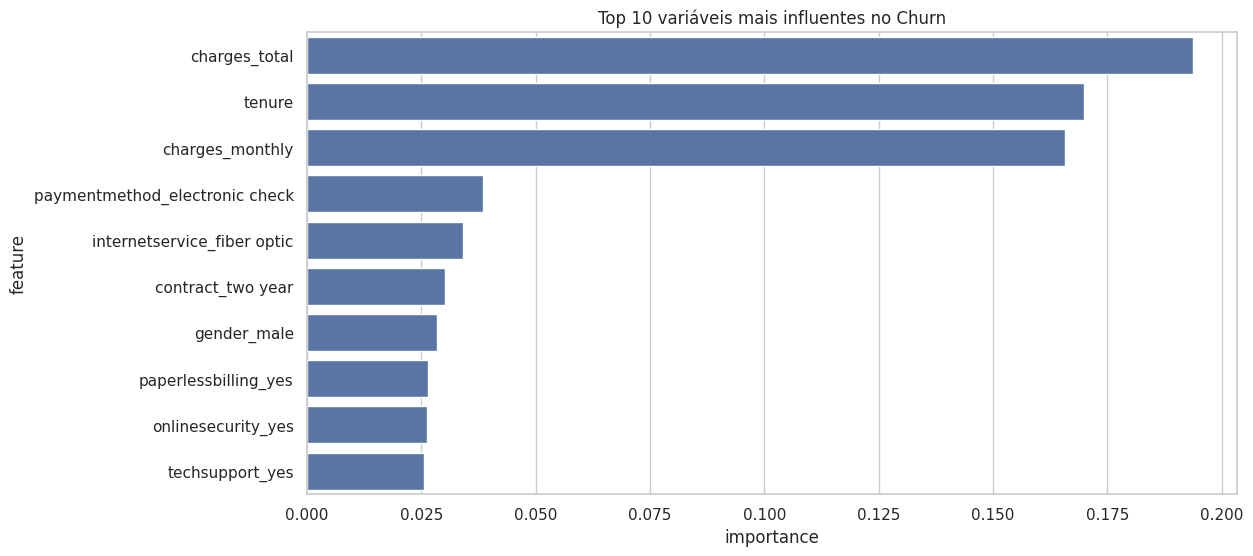

In [ ]:

# 🔍 Importância das variáveis (Random Forest)
importances = rf.feature_importances_
features = X.columns

importancia_df = pd.DataFrame({'feature': features, 'importance': importances})
importancia_df = importancia_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=importancia_df.head(10), x='importance', y='feature')
plt.title('Top 10 variáveis mais influentes no Churn')
plt.show()


In [ ]:

# ✅ Conclusões finais
print("✅ Conclusões:")
print("- Random Forest apresentou melhor desempenho.")
print("- As variáveis mais influentes no churn foram:")
print(importancia_df.head(5)['feature'].values)


✅ Conclusões:
- Random Forest apresentou melhor desempenho.
- As variáveis mais influentes no churn foram:
['charges_total' 'tenure' 'charges_monthly'
 'paymentmethod_electronic check' 'internetservice_fiber optic']


Previsão de Churn em TelecomX
📋 Descrição
Este projeto realiza uma análise e modelagem preditiva para identificar clientes que provavelmente irão cancelar (churn) o serviço da empresa de telecomunicações fictícia TelecomX. Utilizando dados JSON com informações demográficas, de serviço e conta, o objetivo é construir modelos que ajudem a prever o churn com boa acurácia.

🗂️ Dados
Os dados foram obtidos de uma fonte pública no formato JSON, contendo informações aninhadas sobre clientes, telefone, internet e conta:

customer: dados demográficos do cliente (gênero, dependentes, tempo como cliente, etc.)

phone: serviços telefônicos contratados

internet: serviços de internet contratados

account: informações de pagamento e contratos

churn: variável alvo indicando se o cliente cancelou ou não

⚙️ Tecnologias e Bibliotecas
Python 3.x

pandas

numpy

seaborn

matplotlib

scikit-learn

🚀 Passos do projeto
Carregamento e preparação dos dados

Leitura dos dados JSON da URL

Expansão das colunas aninhadas com pd.json_normalize

Combinação dos dados em um DataFrame único

Padronização dos nomes das colunas e tipos de dados

Tratamento de valores faltantes e normalização textual

Engenharia de dados

Codificação da variável alvo (churn) para valores binários

One-hot encoding para variáveis categóricas

Escalonamento dos dados numéricos

Modelagem

Separação dos dados em treino e teste (30% teste)

Treinamento de três modelos:

Regressão Logística

Árvore de Decisão

Random Forest

Avaliação

Análise de métricas: matriz de confusão, relatório de classificação e ROC AUC

Visualização das 10 variáveis mais importantes no modelo Random Forest

📊 Resultados
O modelo Random Forest apresentou o melhor desempenho para prever churn. As variáveis mais importantes foram exibidas em gráfico e listadas no final do código.

